# Requirements

In [9]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 682.7 kB/s eta 0:03:03
   ---------------------------------------- 0.1/124.9 MB 1.3 MB/s eta 0:01:35
   ---------------------------------------- 0.4/124.9 MB 3.4 MB/s eta 0:00:37
   ---------------------------------------- 1.1/124.9 MB 7.7 MB/s eta 0:00:17
   - -------------------------------------- 3.2/124.9 MB 17.0 MB/s eta 0:00:08
   - -------------------------------------- 5.2/124.9 MB 23.9 MB/s eta 0:00:06
   -- ------------------------------------- 6.4/124.9 MB 24.0 MB/s eta 0:00:05
   --- ------------------------------------ 10.9/124.9 MB 59.5 MB/s eta 0:00:02
   ---- ---------------------------------- 15.6/124.9 MB 108.8 MB/s eta 0:00:02
   ----- --------------------------------- 19.2/124.9 MB 110.0 MB/s eta 0:00:01
   ----- --------------------------------- 19.2/124.9 MB 110

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

In [ ]:
# Add as many imports as you need.

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **close price** for the Amazon stock. To accomplish this, you will use data from the preceding 7 days, and past statistics. 


## The Amazon Stock Price Dataset

The dataset comprises the following columns:
- date - the date of the recorded price
- open - the open price of the stock
- high - the high price of the stock
- low - the low price of the stock
- volume - the volume trades
- close - the close price of the stock

Target:
close

Load the dataset into a `pandas` data frame.

In [3]:
data = pd.read_csv('amazon_stock_price.csv')
data.sample(10)

,date,open,high,low,close,volume
2541,2007-06-22,3.4775,3.4940,3.4210,3.4430,167652000
4422,2014-12-10,15.6000,15.6595,15.2340,15.2920,64918000
1985,2005-04-07,1.7340,1.7460,1.7250,1.7450,76146000
1508,2003-05-15,1.6320,1.6375,1.6100,1.6315,103846000
6051,2021-06-02,161.1550,161.7500,160.4000,161.6995,40290000
2153,2005-12-05,2.4430,2.4675,2.4375,2.4415,105018000
1151,2001-12-12,0.6215,0.6215,0.5815,0.5955,161502000
5489,2019-03-11,81.3060,83.6145,81.3005,83.5310,77528000
4654,2015-11-11,33.1625,33.7980,33.1625,33.6625,107746000
4731,2016-03-04,29.0535,29.0700,28.5535,28.7570,68330000


Explore the dataset using visualizations of your choice.

In [5]:
data[['open', 'high', 'low', 'close', 'volume']].corr()

,open,high,low,close,volume
open,1.000000,0.999914,0.999897,0.999790,-0.279792
high,0.999914,1.000000,0.999875,0.999901,-0.278699
low,0.999897,0.999875,1.000000,0.999906,-0.280974
close,0.999790,0.999901,0.999906,1.000000,-0.279841
volume,-0.279792,-0.278699,-0.280974,-0.279841,1.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6685 non-null   object 
 1   open    6685 non-null   float64
 2   high    6685 non-null   float64
 3   low     6685 non-null   float64
 4   close   6685 non-null   float64
 5   volume  6685 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 313.5+ KB


# Feauture Extraction
Select the relevant features for prediction and apply a lag of up to 7 days to each chosen feature

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [9]:
data = data.set_index('date')
data = data.sort_index()
data

,open,high,low,close,volume
date,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000
...,...,...,...,...,...
2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000
2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600
2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200


In [11]:
lag = 7
for i in range(1, lag+1):
    data[f'close_prev_{i}'] = data['close'].shift(i)

data

,open,high,low,close,volume,close_prev_1,close_prev_2,close_prev_3,close_prev_4,close_prev_5,close_prev_6,close_prev_7
date,,,,,,,,,,,,
1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000,0.0979,NaN,NaN,NaN,NaN,NaN,NaN
1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000,0.0865,0.0979,NaN,NaN,NaN,NaN,NaN
1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000,0.0854,0.0865,0.0979,NaN,NaN,NaN,NaN
1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000,0.0818,0.0854,0.0865,0.0979,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,144.7600,146.9300,144.3300,146.0900,65814000,146.3200,147.0300,147.7300,146.7400,146.71,143.90,146.13
2023-12-01,146.0000,147.2500,145.5500,147.0300,39924600,146.0900,146.3200,147.0300,147.7300,146.74,146.71,143.90
2023-12-04,145.2500,145.3500,142.8100,144.8400,48294200,147.0300,146.0900,146.3200,147.0300,147.73,146.74,146.71


In [13]:
data =data.dropna(axis=0)
data.head()

,open,high,low,close,volume,close_prev_1,close_prev_2,close_prev_3,close_prev_4,close_prev_5,close_prev_6,close_prev_7
date,,,,,,,,,,,,
1997-05-27,0.0755,0.0823,0.0729,0.0792,173952000,0.0750,0.0698,0.0714,0.0818,0.0854,0.0865,0.0979
1997-05-28,0.0812,0.0818,0.0766,0.0766,91488000,0.0792,0.0750,0.0698,0.0714,0.0818,0.0854,0.0865
1997-05-29,0.0771,0.0771,0.0740,0.0753,69456000,0.0766,0.0792,0.0750,0.0698,0.0714,0.0818,0.0854
1997-05-30,0.0750,0.0755,0.0740,0.0750,51888000,0.0753,0.0766,0.0792,0.0750,0.0698,0.0714,0.0818
1997-06-02,0.0755,0.0766,0.0750,0.0755,11832000,0.0750,0.0753,0.0766,0.0792,0.0750,0.0698,0.0714


## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [15]:
features = [f'close_prev_{i}' for i in range(1, lag+1)]

In [17]:
X, Y = data[features], data.close
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [69]:
rf_model = RandomForestRegressor(n_estimators=150, max_depth=5, criterion='squared_error')
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5, n_estimators=150)

Use the trained model to make predictions for the test set.

In [71]:
y_pred_rf = rf_model.predict(X_test)
y_pred_rf

array([93.57367853, 93.57367853, 93.57367853, ..., 93.57367853,
       93.57367853, 93.57367853])

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [73]:
mse = mean_squared_error(Y_test, y_pred_rf)
mae = mean_absolute_error(Y_test, y_pred_rf)
r2 = r2_score(Y_test, y_pred_rf)

print('Mean square error:', mse)
print('Mean absolute error: ', mae)
print('R2 score: ', r2)

Mean square error: 1963.8142453274656
Mean absolute error:  33.02523233620962
R2 score:  -0.9301975561646771


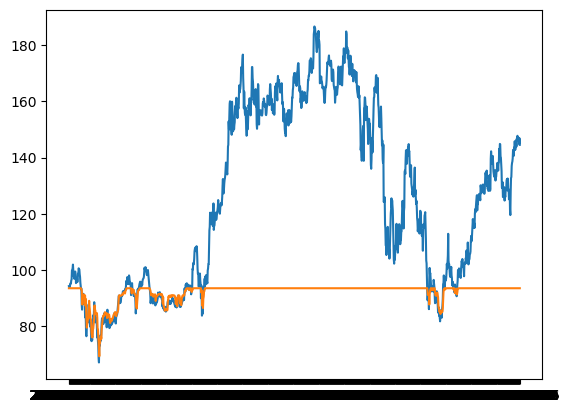

In [75]:
plt.plot(Y_test)
plt.plot(y_pred_rf)

### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [77]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Use the trained model to make predictions for the test set.

In [79]:
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb

array([92.39156, 92.39156, 92.39156, ..., 92.39156, 92.39156, 92.39156],
      dtype=float32)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [81]:
mse = mean_squared_error(Y_test, y_pred_xgb)
mae = mean_absolute_error(Y_test, y_pred_xgb)
r2 = r2_score(Y_test, y_pred_xgb)

print('Mean square error:', mse)
print('Mean absolute error: ', mae)
print('R2 score: ', r2)

Mean square error: 2041.7195755370756
Mean absolute error:  33.89592026026378
R2 score:  -1.00676929829384


In [59]:
from sklearn.model_selection import TimeSeriesSplit

In [83]:
tscv = TimeSeriesSplit(n_splits=7)
model2_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [35, 40, 45, 50, 60, 70, 100, 200],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
grid_search = GridSearchCV(
    estimator=model2_xgb,
    param_grid= param_grid,
    cv = tscv, 
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, Y_train)
best_n_estimator = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
print(f"Best n_estimator: {best_n_estimator}")
print(f"Best max_depth: {best_max_depth}")

Best n_estimator: 100
Best max_depth: 2


In [85]:
final_model = XGBRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=42)
final_model.fit(X_train, Y_train)

y_preds = final_model.predict(X_test)

mse = mean_squared_error(Y_test, y_preds)
mae = mean_absolute_error(Y_test, y_preds)
r2 = r2_score(Y_test, y_preds)

print(f"Final Model Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Mean Absolute Error (MAE): {mae:.4f}")
print(f"  R-squared (R2 Score): {r2:.4f}")

Final Model Performance:
  Mean Squared Error (MSE): 2044.6995
  Mean Absolute Error (MAE): 33.9297
  R-squared (R2 Score): -1.0097


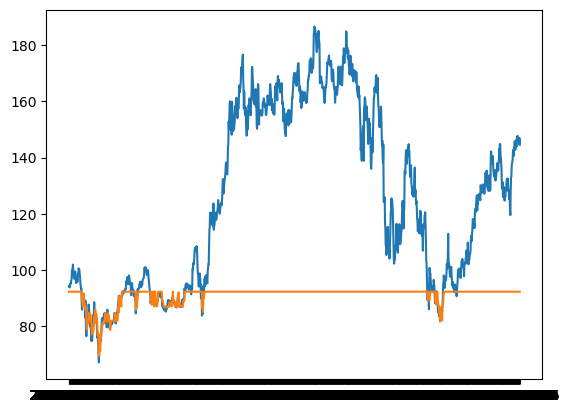

In [89]:
plt.plot(Y_test)
plt.plot(y_preds)
plt.show()